In [2]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib

import sys
sys.path.insert(0, '../../../')
import DLDMD as dl
import LossDLDMD as lf

%matplotlib inline

In [3]:
# Figure parameters
plot_save_path = './analysis_results/'
font = {'family': 'DejaVu Sans', 'size': 18}
matplotlib.rc('font', **font)
fontsize = 18
figsize = (15, 10)
dpisave = 300

# Initialize the compute device
DEVICE = '/GPU:0'
GPUS = tf.config.experimental.list_physical_devices('GPU')
if GPUS:
    try:
        for gpu in GPUS:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    DEVICE = '/CPU:0'

tf.keras.backend.set_floatx('float64')
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Num GPUs available: {}".format(len(GPUS)))
print("Running on device: {}".format(DEVICE))

TensorFlow version: 2.7.0
Eager execution: True
Num GPUs available: 0
Running on device: /CPU:0


In [4]:
# SET THIS PATH (w/o file extension!). Both '.pkl' and '.h5' files should have same name
model_path = './lorenz96_2023-01-12-2249/epoch_100_loss_0.215'
model_hyp_params = model_path + '.pkl'
model_weights = model_path + '.h5'

# Load the hyper parameters
hyp_params = pickle.load(open(model_hyp_params, 'rb'))

# Set Tensorflow backend precision
tf.keras.backend.set_floatx(hyp_params['precision'])
print("Using precision: {}\n".format(tf.keras.backend.floatx()))

# Load test data
test_data = pickle.load(open('data_test.pkl', 'rb'))
print("Test data shape: {}".format(test_data.shape))

Using precision: float64

Test data shape: (2000, 600, 5)


In [5]:
# Fix hyper parameters for running the model on test data
hyp_params['pretrain'] = False
hyp_params['batch_size'] = test_data.shape[0]

# Load the trained DLDMD model weights
model = dl.DLDMD(hyp_params)
model(test_data)
model.load_weights(model_weights)

# Initialize the loss function
loss = lf.LossDLDMD(hyp_params)
print("Number of prediction steps: ", model.num_time_steps - model.num_recon_steps)

Number of prediction steps:  100


In [6]:
with tf.device(DEVICE):
    preds = model(test_data, training=False)
    losses = loss(preds, test_data)

[y, x_ae, x_adv, y_adv, weights, evals, evecs, phi] = preds
print("Loss: {loss:2.7f}".format(loss=losses.numpy()))
print("Log10 Loss: {loss:2.7f}".format(loss=np.log10(losses.numpy())))

Loss: 1.3397416
Log10 Loss: 0.1270210


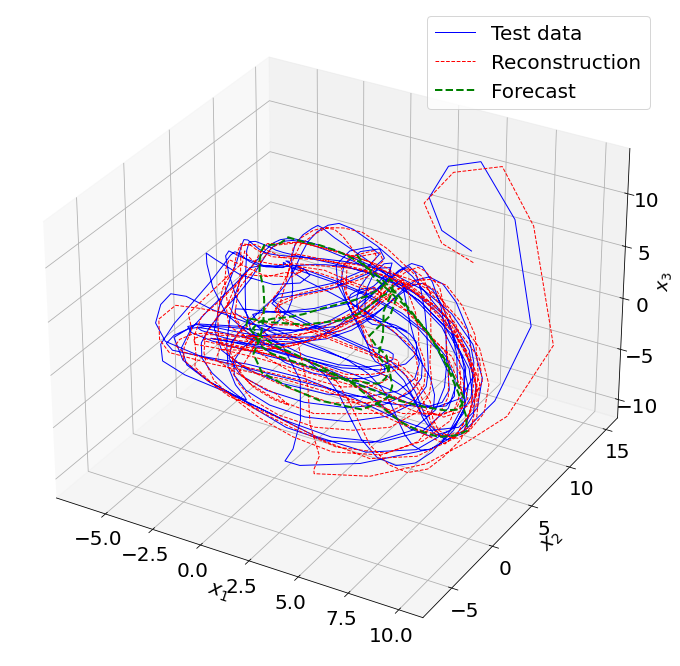

In [7]:
fs = 20
ts = 20
lw = 1
ms = 1000
figsize = (12, 12)
skip = 1

# DLDMD reconstruction
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=figsize,facecolor='white')
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot3D(test_data[0, :, 0], test_data[0, :, 1], test_data[0, :, 2], 'b', linestyle='solid', lw=lw, label='Test data')
ax.plot3D(x_adv[0, :-99, 0], x_adv[0, :-99, 1], x_adv[0, :-99, 2], 'r', linestyle='dashed', lw=lw, label='Reconstruction')
ax.plot3D(x_adv[0, -100:, 0], x_adv[0, -100:, 1], x_adv[0, -100:, 2], 'g', linestyle='dashed', lw=2*lw, label='Forecast')
plt.xlabel(r'$x$', fontsize=fs)
plt.ylabel(r'$\dot{x}$', fontsize=fs)
plt.legend(fontsize=fs, loc='upper right')
#plt.axis('equal')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=ts)
ax.tick_params(axis='both', which='minor', labelsize=ts)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')

fig.savefig("dldmd_test_lorenz_96_pplane", dpi=dpisave)
plt.show()

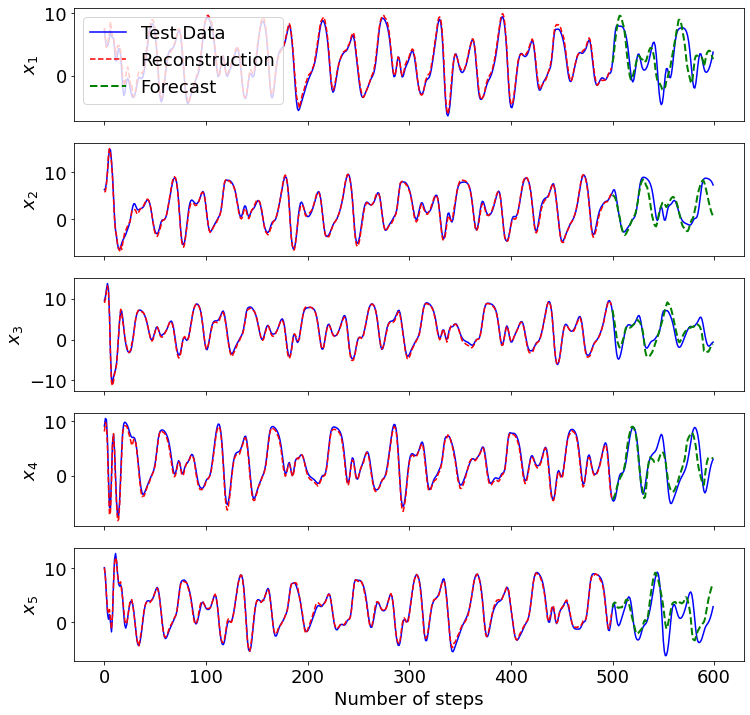

In [20]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=figsize,facecolor='white')
num_steps = range(hyp_params['num_time_steps'])
num_steps_1 =range(hyp_params['num_time_steps'] - 100)
num_steps_2 =np.arange(500,600,1)

axes[0].plot(num_steps,test_data[0, :, 0],'b',linestyle='solid',label = 'Test Data')
axes[0].plot(num_steps_1,x_adv[0,:-100,0],'r',linestyle='dashed',label = 'Reconstruction')
axes[0].plot(num_steps_2,x_adv[0,-100:,0],'g',linestyle='dashed',lw = 2*lw,label = 'Forecast')
axes[0].set_ylabel('$x_1$')
axes[0].legend(loc = 'upper left')

axes[1].plot(num_steps,test_data[0, :, 1],'b',linestyle='solid',label = 'Test Data')
axes[1].plot(num_steps_1,x_adv[0,:-100,1],'r',linestyle='dashed',label = 'Reconstruction')
axes[1].plot(num_steps_2,x_adv[0,-100:,1],'g',linestyle='dashed',lw = 2*lw,label = 'Forecast')
axes[1].set_ylabel('$x_2$')


axes[2].plot(num_steps,test_data[0, :, 2],'b',linestyle='solid',label = 'Test Data')
axes[2].plot(num_steps_1,x_adv[0,:-100,2],'r',linestyle='dashed',label = 'Reconstruction')
axes[2].plot(num_steps_2,x_adv[0,-100:,2],'g',linestyle='dashed',lw = 2*lw,label = 'Forecast')
axes[2].set_ylabel('$x_3$')

axes[3].plot(num_steps,test_data[0, :, 3],'b',linestyle='solid',label = 'Test Data')
axes[3].plot(num_steps_1,x_adv[0,:-100,3],'r',linestyle='dashed',label = 'Reconstruction')
axes[3].plot(num_steps_2,x_adv[0,-100:,3],'g',linestyle='dashed',lw = 2*lw,label = 'Forecast')
axes[3].set_ylabel('$x_4$')

axes[4].plot(num_steps,test_data[0, :, 4],'b',linestyle='solid',label = 'Test Data')
axes[4].plot(num_steps_1,x_adv[0,:-100,4],'r',linestyle='dashed',label = 'Reconstruction')
axes[4].plot(num_steps_2,x_adv[0,-100:,4],'g',linestyle='dashed',lw = 2*lw,label = 'Forecast')
axes[4].set_ylabel('$x_5$')
axes[4].set_xlabel('Number of steps')

fig.savefig("dldmd_test_lorenz96_xyz_over_num_steps", dpi=dpisave)

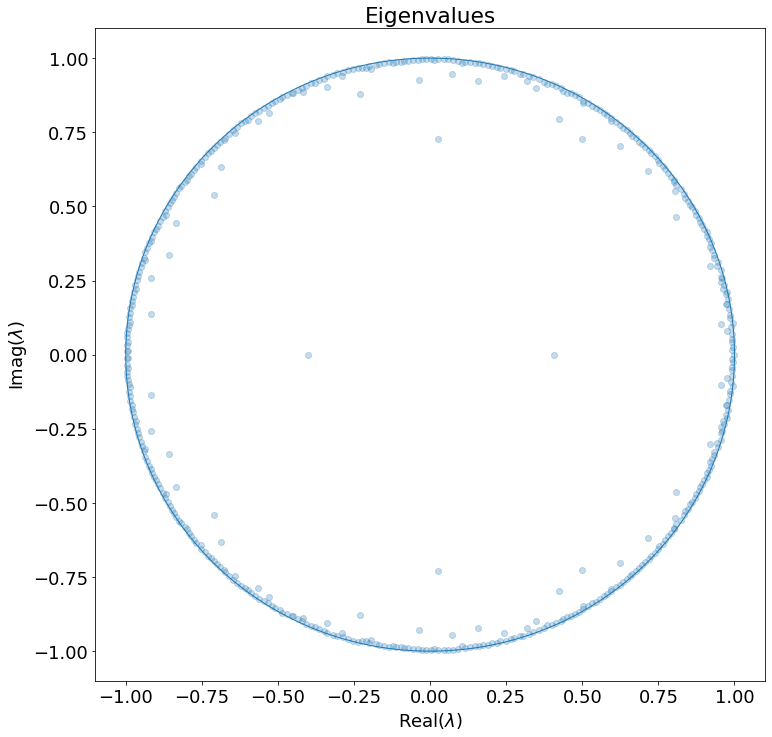

In [ ]:
#Eigenvalues
fig = plt.figure(figsize=figsize,facecolor='white')
ax = fig.add_subplot(111)
t = np.linspace(0, 2*np.pi, 300)
ax.plot(np.cos(t), np.sin(t), linewidth=1)
ax.scatter(np.real(evals), np.imag(evals),alpha = 0.25)
ax.set_xlabel("Real$(\lambda)$")
ax.set_ylabel("Imag$(\lambda)$")
ax.set_title("Eigenvalues")
fig.savefig("dldmd_test_lorenz_96_evals", dpi=dpisave)